In [10]:
import os
import shutil
from pathlib import Path
import cv2
import yaml  # This was missing!
from PIL import Image
from roboflow import Roboflow
import torch
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from tqdm import tqdm

In [6]:
rf = Roboflow(api_key= 'pvOUIjcv7gdFcMxVMGTs')
project = rf.workspace("default-kupxs").project("counterfeit-nike-shoes-detection")
dataset = project.version(1).download("yolov8")
print(f"Dataset downloaded to: {dataset.location}")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to counterfeit-nike-shoes-detection-1 in yolov8::

Dataset downloaded to: /Users/mesharyalbutti/AI/LearningAI/counterfeit-nike-shoes-detection-1


In [11]:
def convert_detection_to_classification_full_images(dataset_location, output_dir="classification_data_full"):
    """
    Convert object detection dataset to classification format using full images
    """
    dataset_path = Path(dataset_location)
    output_path = Path(output_dir)
    
    # Read the data.yaml file
    yaml_path = dataset_path / 'data.yaml'
    with open(yaml_path, 'r') as f:
        data_config = yaml.safe_load(f)
    
    class_names = data_config['names']
    print(f"Found classes: {class_names}")
    
    # Create output directory structure
    for split in ['train', 'valid', 'test']:
        for class_type in ['real', 'fake']:
            (output_path / split / class_type).mkdir(parents=True, exist_ok=True)
    
    # Process each split
    for split in ['train', 'valid', 'test']:
        split_img_dir = dataset_path / split / 'images'
        split_label_dir = dataset_path / split / 'labels'
        
        if not split_img_dir.exists():
            print(f"Warning: {split} split not found")
            continue
            
        print(f"\nProcessing {split} split...")
        
        real_count = 0
        fake_count = 0
        
        # Process each image
        for img_file in split_img_dir.glob('*.[jp][pn][g]'):
            label_file = split_label_dir / (img_file.stem + '.txt')
            
            if not label_file.exists():
                print(f"Warning: No label file for {img_file.name}")
                continue
            
            # Read labels to determine predominant class
            with open(label_file, 'r') as f:
                lines = f.readlines()
            
            if len(lines) == 0:
                continue
            
            # Get the first object's class (or you could use majority voting)
            class_id = int(lines[0].split()[0])
            class_name = class_names[class_id].lower()
            
            # Determine if real or fake based on keywords
            if 'original' in class_name or 'real' in class_name or 'authentic' in class_name:
                target_class = 'real'
                real_count += 1
            elif 'fake' in class_name or 'counterfeit' in class_name or 'replica' in class_name:
                target_class = 'fake'
                fake_count += 1
            else:
                # Default classification based on common patterns
                if 'jordan' in class_name and 'fake' not in class_name:
                    target_class = 'real'
                    real_count += 1
                else:
                    print(f"Warning: Can't classify {class_name}, skipping")
                    continue
            
            # Copy full image to appropriate folder
            output_file = output_path / split / target_class / img_file.name
            shutil.copy2(img_file, output_file)
        
        print(f"  real: {real_count} images")
        print(f"  fake: {fake_count} images")
    
    print(f"\nDataset converted and saved to: {output_path}")
    return output_path

# Run the conversion
classification_data_path = convert_detection_to_classification_full_images(dataset.location)


Found classes: ['nike fake air force', 'nike fake jordan 1', 'nike original air force', 'nike original jordan 1']

Processing train split...
  real: 1268 images
  fake: 1435 images

Processing valid split...
  real: 356 images
  fake: 415 images

Processing test split...
  real: 191 images
  fake: 195 images

Dataset converted and saved to: classification_data_full


In [13]:
train_transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),        
    transforms.ColorJitter(brightness=0.2,        
                          contrast=0.2,             
                          saturation=0.2,          
                          hue=0.1),                
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                        std=[0.229, 0.224, 0.225])

])

val_test_transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                        std=[0.229, 0.224, 0.225])
])

In [14]:
train_ds = datasets.ImageFolder('classification_data_full/train',transform=train_transform)
valid_ds = datasets.ImageFolder('classification_data_full/valid', transform=val_test_transform)
test_ds = datasets.ImageFolder('classification_data_full/test', transform=val_test_transform)

In [41]:
batch_size = 32
train_loader = DataLoader(train_ds,batch_size, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_ds,batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_ds,batch_size, shuffle=False, num_workers=4)

In [19]:
print(f" Training samples: {len(train_ds)} ")
print(f" Validation samples: {len(valid_ds)} ")
print(f" Test samples: {len(test_ds)} ")

 Training samples: 2703 
 Validation samples: 771 
 Test samples: 386 


In [30]:
from torchvision import models
from torchvision.models import ResNet50_Weights

model = models.resnet50(weights=ResNet50_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /Users/mesharyalbutti/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████████████████████████████████| 97.8M/97.8M [00:10<00:00, 10.2MB/s]


In [31]:
num_features = model.fc.in_features

In [33]:
for name, param in model.named_parameters():
    if 'layer4' not in name and 'fc' not in name:
        param.requires_grad = False

model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_features, 512),
    nn.ReLU(),
    nn.BatchNorm1d(512),
    nn.Dropout(0.3),
    nn.Linear(512, 2)
)

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = model.to(device)

# Check trainable parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f" Model loaded on: {device}")
print(f" Total parameters: {total_params:,}")
print(f" Trainable parameters: {trainable_params:,}")
print(f" Training only {(trainable_params/total_params)*100:.1f}% of the model")

 Model loaded on: mps
 Total parameters: 24,559,170
 Trainable parameters: 16,015,874
 Training only 65.2% of the model


In [36]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW([
    {'params': model.fc.parameters(), 'lr': 0.001},
    {'params': model.layer4.parameters(), 'lr': 0.0001}
], weight_decay=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                mode='min',
                                                patience=3,
                                                factor=0.5)

In [39]:
from tqdm import tqdm
import time

def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    best_valid_acc = 0.0
    history = {'train_loss': [], 'valid_loss': [], 'train_acc': [], 'valid_acc': []}
    
    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 50)
        
        # TRAINING PHASE
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        
        train_pbar = tqdm(train_loader, desc='Training', leave=False)
        for images, labels in train_pbar:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            optimizer.zero_grad()
            loss.backward()
            
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            
            train_pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{100*correct/total:.2f}%'
            })
        
        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total
        
        
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        
        valid_pbar = tqdm(valid_loader, desc='Validation', leave=False)
        with torch.no_grad():
            for images, labels in valid_pbar:
                images, labels = images.to(device), labels.to(device)
                
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
                valid_pbar.set_postfix({
                    'loss': f'{loss.item():.4f}',
                    'acc': f'{100*correct/total:.2f}%'
                })
        
        valid_loss = running_loss / len(valid_loader)
        valid_acc = 100 * correct / total
        
        
        scheduler.step(valid_loss)
        
        history['train_loss'].append(train_loss)
        history['valid_loss'].append(valid_loss)
        history['train_acc'].append(train_acc)
        history['valid_acc'].append(valid_acc)
        
        
        print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%')
        print(f'Valid Loss: {valid_loss:.4f} | Valid Acc: {valid_acc:.2f}%')
        print(f'Learning Rate: {optimizer.param_groups[0]["lr"]:.6f}')
        
        # Save best model
        if valid_acc > best_valid_acc:
            best_valid_acc = valid_acc
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_acc': best_valid_acc,
            }, 'best_sneaker_model.pth')
            print(f'✓ Saved best model with {best_valid_acc:.2f}% accuracy')
    
    print(f'\n✓ Training complete! Best accuracy: {best_valid_acc:.2f}%')
    return history

In [43]:
history = train_model(model, criterion, optimizer, scheduler, num_epochs=10)


Epoch 1/10
--------------------------------------------------


Train Loss: 0.4488 | Train Acc: 78.84%
Valid Loss: 0.3668 | Valid Acc: 84.18%
Learning Rate: 0.001000
✓ Saved best model with 84.18% accuracy

Epoch 2/10
--------------------------------------------------


Train Loss: 0.3331 | Train Acc: 86.20%
Valid Loss: 0.2895 | Valid Acc: 87.16%
Learning Rate: 0.001000
✓ Saved best model with 87.16% accuracy

Epoch 3/10
--------------------------------------------------


Train Loss: 0.2567 | Train Acc: 89.31%
Valid Loss: 0.2411 | Valid Acc: 88.98%
Learning Rate: 0.001000
✓ Saved best model with 88.98% accuracy

Epoch 4/10
--------------------------------------------------


Train Loss: 0.2144 | Train Acc: 91.49%
Valid Loss: 0.2819 | Valid Acc: 87.68%
Learning Rate: 0.001000

Epoch 5/10
--------------------------------------------------


Train Loss: 0.1693 | Train Acc: 93.04%
Valid Loss: 0.1999 | Valid Acc: 92.22%
Learning Rate: 0.001000
✓ Saved best model with 92.22% accuracy

Epoch 6/10
--------------------------------------------------


Train Loss: 0.1333 | Train Acc: 95.19%
Valid Loss: 0.2623 | Valid Acc: 90.14%
Learning Rate: 0.001000

Epoch 7/10
--------------------------------------------------


Train Loss: 0.1192 | Train Acc: 95.82%
Valid Loss: 0.2605 | Valid Acc: 91.83%
Learning Rate: 0.001000

Epoch 8/10
--------------------------------------------------


Train Loss: 0.1077 | Train Acc: 96.56%
Valid Loss: 0.2776 | Valid Acc: 90.53%
Learning Rate: 0.001000

Epoch 9/10
--------------------------------------------------


Train Loss: 0.0846 | Train Acc: 97.04%
Valid Loss: 0.2529 | Valid Acc: 92.09%
Learning Rate: 0.000500

Epoch 10/10
--------------------------------------------------


Train Loss: 0.0585 | Train Acc: 98.00%
Valid Loss: 0.2183 | Valid Acc: 93.77%
Learning Rate: 0.000500
✓ Saved best model with 93.77% accuracy

✓ Training complete! Best accuracy: 93.77%


In [44]:
def evaluate(dataloader):
    model.eval()  
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0
    
    
    with torch.no_grad():
        for text_batch, label_batch in dataloader:  
            text_batch = text_batch.to(device)
            label_batch = label_batch.to(device)
            
            outputs = model(text_batch)
            loss = criterion(outputs, label_batch)
            running_loss += loss.item()

            
            _, predicted = torch.max(outputs, 1)
            correct_preds += (predicted == label_batch).sum().item()
            total_preds += label_batch.size(0)

    accuracy = (correct_preds / total_preds) * 100
    avg_loss = running_loss / len(dataloader)
    return accuracy, avg_loss

In [45]:
test_accuracy, test_loss = evaluate(test_loader)
print(f'Test Accuracy: {test_accuracy:.2f}%')
print(f'Test Loss: {test_loss:.4f}')

Test Accuracy: 93.52%
Test Loss: 0.2398


In [46]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    """
    Plot training and validation losses and accuracies.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # Plot losses
    ax1.plot(history['train_loss'], label='Train Loss')
    ax1.plot(history['valid_loss'], label='Valid Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    ax1.grid(True)
    
    # Plot accuracies
    ax2.plot(history['train_acc'], label='Train Accuracy')
    ax2.plot(history['valid_acc'], label='Valid Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title('Training and Validation Accuracy')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

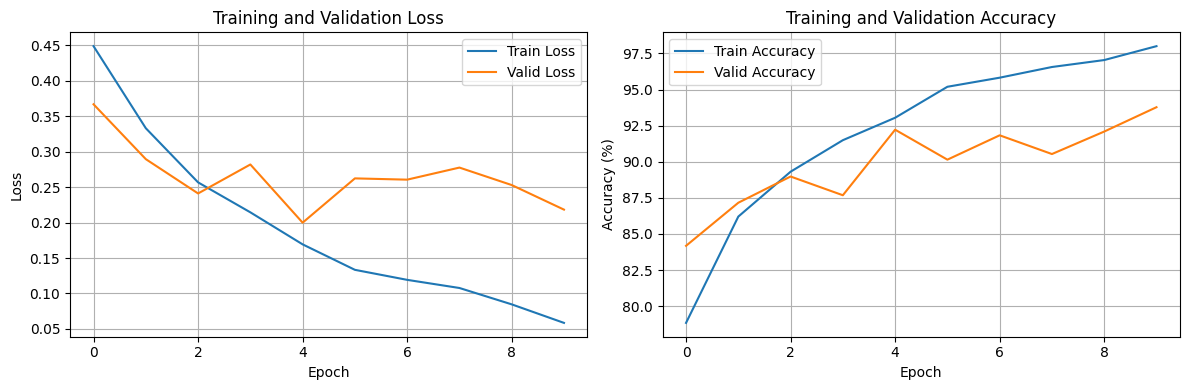

In [47]:
plot_training_history(history)